<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo05-resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning a ResNet

Modern deep convnets tend to have tens (if not hundreds) of layers, with millions (if not tens of millions) of trainable parameters. More often than not several of these layers have skipped connections; the *ResNet* family of networks are an example.

The flip side of having such deep network architectures is that to properly learn such networks, one requires *massive* amounts of training data. In most applications, access to such massive datasets simply isn't available; gathering and curating a dataset with a few hundred/thousand examples itself can be a challenge.

What should one do in the "small data" setting? A possible solution:
* start with a deep network architecture initialized with *pre-trained* weights, and
* *fine-tune* the network weights on the (small) training dataset.

In this demo we will see how to train a simple cat-vs-dog classifier using a very small training dataset of 60 images. The dataset is provided [here](https://github.com/chinmayhegde/dl-demos/blob/main/data.zip). You can unzip and save the dataset anywhere you like; I've saved it to my Google drive folder: `MyDrive/data`.

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

# Limit warnings LOL
import logging
logger = logging.getLogger()
logger.setLevel(100)

Since I put the data in `MyDrive/data`, I'll have to give colab access to the folder so we can load it.

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:

# data transforms
dset_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"/content/drive/MyDrive/data/{x}", dset_transform)
         for x in ['train', 'val']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
                                              shuffle=True)
               for x in ['train', 'val']}


Let's take a look at some of the data.

In [85]:
imgs, labels = next(iter(dataloaders['train']))
print(imgs.shape)


torch.Size([16, 3, 224, 224])


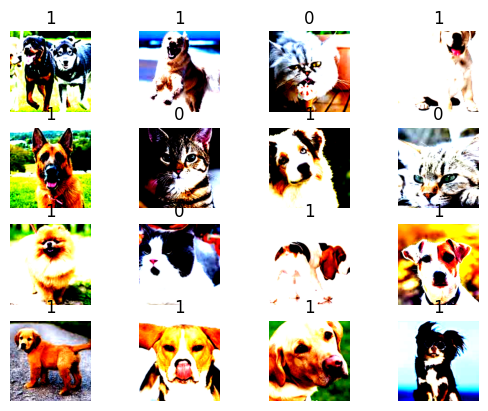

In [86]:
def plot_images(imgs, labels, nrows=4, ncols=4):
  fig, axes = plt.subplots(nrows, ncols)
  idx = 0
  for i in range(nrows):
    for j in range(ncols):
      ax = axes[i,j]
      ax.imshow(imgs[idx].permute(1,2,0))
      ax.set_title(labels[idx].item())
      ax.axis('off')
      idx += 1
  plt.show()


plot_images(imgs, labels)

The warning is because some of the pixel values are being squished to a smaller range. We can see this in the strange coloration of the images.

# Loading a pre-trained ResNet model

Let's load a ResNet34 model from `torchvision` and examine it.

The residual connections allow for data to "skip" part of the network. Why would this be beneficial?

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/ResBlock.png/440px-ResBlock.png)

In [87]:
# intialize model
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Hmm, lots of layers. Each `BasicBlock` is two or three conv layers with a skipped connection, with batch-norm layers thrown in for good measure. Several such residual blocks are pieced together, and in the end there is a dense layer with 1000 output neurons. This model has been trained on the well-known *ImageNet* dataset (which has over a million images with 1000 classes). As an aside, let's examine the number of trainable parameters in the model.

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

21797672


Let us finetune this model for our cat-vs-dog classification problem. Since this is a binary classifier we will redefine the output (linear) layer to have 2 outputs.

In [90]:
num_ftrs = model.fc.in_features
print(num_ftrs)

512


In [91]:
model.fc = nn.Linear(num_ftrs, 2)

In [92]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Observe now that the basic ResNet34 backbone remains the same; only the output layer has changed. In fact, all of the weights (except the output layer) also have been retained.  

Let's do a quick model evaluation to check if there are any errors thrown during prediction.

In [93]:
model.eval()
corrects = 0
for batch_idx, (inputs,labels) in enumerate(dataloaders['val'], 1):
  with torch.set_grad_enabled(False):
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)

  corrects += torch.sum(preds == labels.data)

print(corrects.float() / len(dataloaders['val'].dataset))

tensor(0.6250)


Let's see the predictions with our animal pictures!

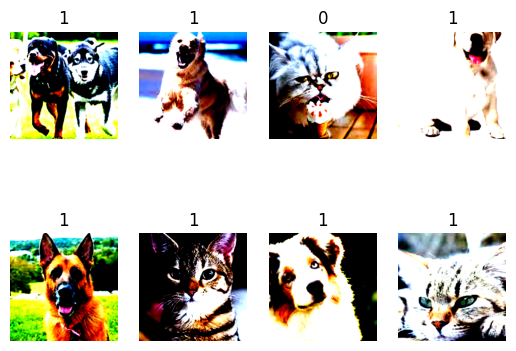

In [94]:
plot_images(imgs, preds, nrows=2, ncols=4)

As we can see, we get an accuracy of 50\% on the test set -- which is exactly what we would expect since the weights of the output layer are random.

We are now ready to start fine-tuning! The rest of the code below is boilerplate training; we see below that only a few epochs are enough to tune the weights to our training dataset.  

In [95]:
# define loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [96]:
for epoch in range(4):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        # pretty print
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:0.50 -- Acc:81.67
Epoch:0 -- Phase:val -- Loss:0.45 -- Acc:83.33
Epoch:1 -- Phase:train -- Loss:0.27 -- Acc:100.00
Epoch:1 -- Phase:val -- Loss:0.26 -- Acc:91.67
Epoch:2 -- Phase:train -- Loss:0.18 -- Acc:98.33
Epoch:2 -- Phase:val -- Loss:0.17 -- Acc:95.83
Epoch:3 -- Phase:train -- Loss:0.07 -- Acc:100.00
Epoch:3 -- Phase:val -- Loss:0.10 -- Acc:95.83


Text(0.5, 1.0, 'Accuracy')

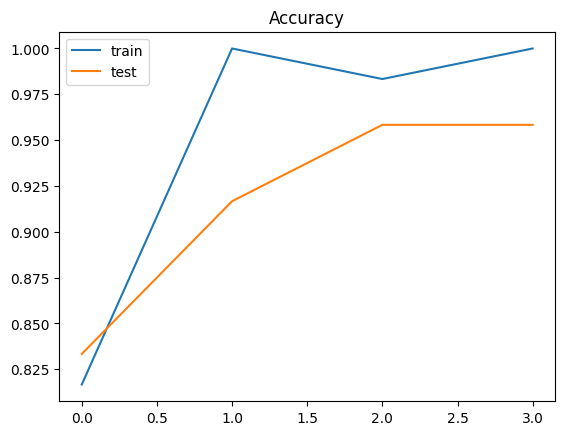

In [97]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "test"])
plt.title("Accuracy")


There we go! That took only 4 epochs of finetuning.

This was a very small dataset (of only 60 training images) so it is not that surprising that we were able to fit the data so easily. Let's see how we're doing now.

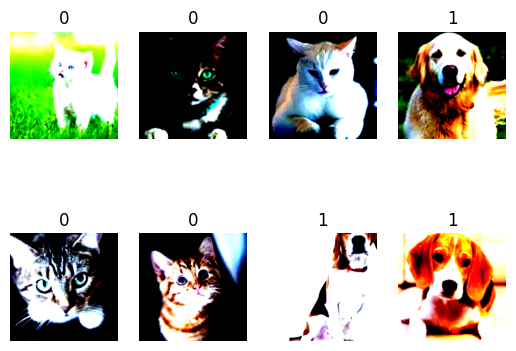

In [98]:
plot_images(inputs, preds, nrows=2, ncols=4)

Sure enough, we were very quickly able to learn the difference between cats and dogs! Before we finish, let's explore why residual networks are special.

### Why Residual Connections?

There are two commonly accepted reasons why residual connections are useful in networks:

1. Residual connections allow important information to propagate through the network without being modified by unnecessary weights.

2. Residual connections allow gradient updates directly to weights that are early on in the network.

These reasons are abstract. Let's look at a low-dimensional visualization of the loss "landscape" of different types of networks.

<img src="https://www.cs.umd.edu/~tomg/img/landscapes/noshort.png" width="300" />

<img src="https://www.cs.umd.edu/~tomg/img/landscapes/shortHighRes.png" width="300"/>

The image on the left is a network called VGG-56. The image on the right is the *same* network but with residual connections.

These plots are acquired by taking the trained parameters $\theta^* \in \mathbb{R}^d$ and perturbing them in two random directions $\delta, \eta \in \mathbb{R}^d$. The plot we're looking at is $f(x,y)$ where $x,y \in \mathbb{R}$ and

$$
f(x,y) = L(\theta^* + x \delta + y \eta).
$$

Amazingly, the network with residual connections is much smoother than the network without residual connections!

The phenonomen is described in more detail [here](https://www.telesens.co/2019/01/16/neural-network-loss-visualization/) and there's a wonderful interactive visualization tool we can play with [here](http://www.telesens.co/loss-landscape-viz/viewer.html).